In [1]:
import numpy as np
import matplotlib.pyplot as plt
from crweno5_scheme import crweno5_nonlinear_weights
from rk3 import rk3

ghost_cells_n = 2

x_l, x_r, t = 0, 1, 0.25
nx = 200
dt = 0.0001
dx = (x_r - x_l) / nx
nt = int(t / dt)

# u[-2, -1, 0, 1, 2, ... N, N+1, N+2]
u = np.zeros((nt + 1, nx + 1 + 2 * ghost_cells_n))
x = np.linspace(x_l - ghost_cells_n * dx, x_r + ghost_cells_n * dx, nx + 1 + 2 * ghost_cells_n)

u[0, :] = np.sin(2 * np.pi * x)

In [2]:
def right_hand_side(u0):
    
    rhs_buffer = np.zeros(nx-1)
    a, b, c, r = np.zeros(nx), np.zeros(nx), np.zeros(nx), np.zeros(nx)
    uL, uR = np.zeros(nx), np.zeros(nx)
    
    for i in range(nx):
        value = (u0[i], u0[i+1], u0[i+2], u0[i+3], u0[i+4])
        a1, a2, a3, b1, b2, b3 = crweno5_nonlinear_weights(value)
        a[i], b[i], c[i], r[i] = a1, a2, a3, b1 * u0[i+1] + b2 * u0[i+2] + b3 * u0[i+3]
    
    alpha, beta = c[-1], a[0]
    A = np.diag(b) + np.diag(c[:-1], 1) + np.diag(a[1:], -1) + np.diag([beta], nx-1) + np.diag([alpha], -(nx-1))
    uL = np.linalg.solve(A, r)
    
    for i in range(nx):
        value = (u0[i+5], u0[i+4], u0[i+3], u0[i+2], u0[i+1])
        a1, a2, a3, b1, b2, b3 = crweno5_nonlinear_weights(value)
        a[i], b[i], c[i], r[i] = a1, a2, a3, b1 * u0[i+4] + b2 * u0[i+3] + b3 * u0[i+2]
    
    alpha, beta = c[-1], a[0]
    A = np.diag(b) + np.diag(c[:-1], 1) + np.diag(a[1:], -1) + np.diag([beta], nx-1) + np.diag([alpha], -(nx-1))
    uR = np.linalg.solve(A, r)
    
    for i in range(nx-1):
        if u0[i+ghost_cells_n+1] > 0:
            rhs_buffer[i] = -u0[i+ghost_cells_n+1] * (uL[i+1] - uL[i]) / dx
        else:
            rhs_buffer[i] = -u0[i+ghost_cells_n+1] * (uR[i+1] - uR[i]) / dx
            
    return rhs_buffer

## Dirichlet boundary

In [3]:
# for Dirichlet boundary
def update_ghost_cells(buffer):
    buffer[0], buffer[1], buffer[2] = 3 * buffer[ghost_cells_n] - 2 * buffer[ghost_cells_n+1], 2 * buffer[ghost_cells_n] - buffer[ghost_cells_n+1], 0
    buffer[-1], buffer[-2], buffer[-3] = 3 * buffer[nx+ghost_cells_n] - 2 * buffer[nx+ghost_cells_n-1], 2 * buffer[nx+ghost_cells_n] - buffer[nx+ghost_cells_n-1], 0

In [4]:
intermediate = np.zeros_like(x)
to_update_slice = slice(ghost_cells_n+1, nx+ghost_cells_n)

for i in range(1, nt+1):
    
    buffer = right_hand_side(u[i-1])
    intermediate[to_update_slice] = rk3(1, u[i-1, to_update_slice], buffer, dt, None)
    update_ghost_cells(intermediate)
    
    buffer = right_hand_side(intermediate)
    intermediate[to_update_slice] = rk3(2, u[i-1, to_update_slice], buffer, dt, intermediate[to_update_slice])
    update_ghost_cells(intermediate)
    
    buffer = right_hand_side(intermediate)
    intermediate[to_update_slice] = rk3(3, u[i-1, to_update_slice], buffer, dt, intermediate[to_update_slice])
    update_ghost_cells(intermediate)
    
    u[i] = intermediate

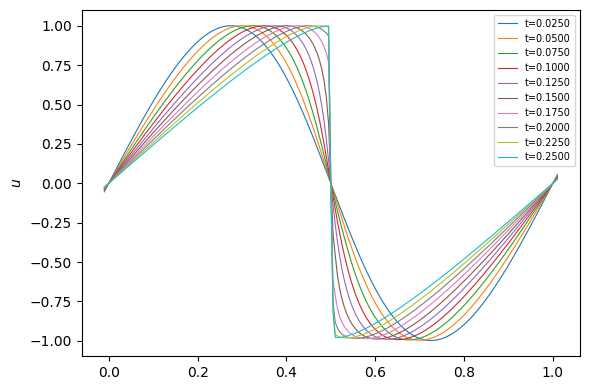

In [5]:
ts = np.linspace(0.025, 0.25, 10)
plt.figure(figsize=(6, 4), dpi=100)
for i, t_stamp in enumerate(ts):
    index = int(t_stamp / dt)
    plt.plot(x, u[index], linewidth=0.8, label="t="+format(t_stamp, ".4f"))
plt.legend(fontsize=7)
plt.ylabel("$x$")
plt.ylabel("$u$")
plt.tight_layout()

## Periodic boundary

In [6]:
# for periodic boundary
def update_ghost_cells(buffer):
    buffer[0], buffer[1], buffer[2] = buffer[nx], buffer[nx+1], 0
    buffer[-1], buffer[-2], buffer[-3] = buffer[2*ghost_cells_n], buffer[2*ghost_cells_n-1], 0

In [7]:
intermediate = np.zeros_like(x)
to_update_slice = slice(ghost_cells_n+1, nx+ghost_cells_n)

for i in range(1, nt+1):
    
    buffer = right_hand_side(u[i-1])
    intermediate[to_update_slice] = rk3(1, u[i-1, to_update_slice], buffer, dt, None)
    update_ghost_cells(intermediate)
    
    buffer = right_hand_side(intermediate)
    intermediate[to_update_slice] = rk3(2, u[i-1, to_update_slice], buffer, dt, intermediate[to_update_slice])
    update_ghost_cells(intermediate)
    
    buffer = right_hand_side(intermediate)
    intermediate[to_update_slice] = rk3(3, u[i-1, to_update_slice], buffer, dt, intermediate[to_update_slice])
    update_ghost_cells(intermediate)
    
    u[i] = intermediate

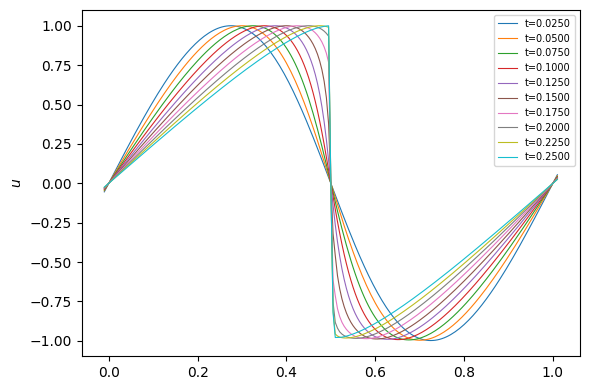

In [8]:
ts = np.linspace(0.025, 0.25, 10)
plt.figure(figsize=(6, 4), dpi=100)
for i, t_stamp in enumerate(ts):
    index = int(t_stamp / dt)
    plt.plot(x, u[index], linewidth=0.8, label="t="+format(t_stamp, ".4f"))
plt.legend(fontsize=7)
plt.ylabel("$x$")
plt.ylabel("$u$")
plt.tight_layout()